In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [3]:
from sklearn.datasets import load_digits
#X, y = load_digits(return_X_y=True, as_frame=True)
digits = load_digits()
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

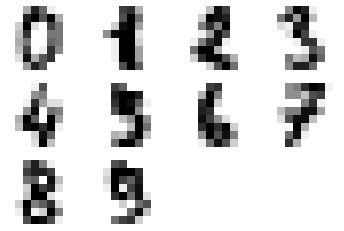

In [4]:
fig, axs = plt.subplots(3, 4)
for i in range(12):
    axs.flat[i].set_axis_off()
    if i<10:
        axs.flat[i].imshow(digits.images[i],cmap=plt.cm.gray_r)

plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [5]:
agg = AgglomerativeClustering(n_clusters=10)
agg_pred = agg.fit_predict(X, y)
agg_pred.shape

(1797,)

In [6]:
km = KMeans(n_clusters=10, n_init=100)
km_pred = km.fit_predict(X, y)
km_pred.shape

(1797,)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

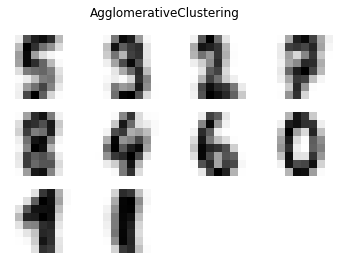

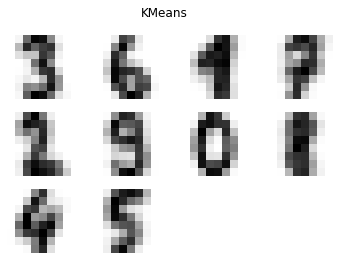

In [7]:
fig, axs = plt.subplots(3, 4)
fig.suptitle('AgglomerativeClustering')
for i in range(10):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[agg_pred == i].mean(axis=0).reshape(8,8),cmap=plt.cm.gray_r)
axs.flat[10].set_axis_off()
axs.flat[11].set_axis_off()
plt.show()

fig, axs = plt.subplots(3, 4)
fig.suptitle('KMeans')
for i in range(10):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[km_pred == i].mean(axis=0).reshape(8,8),cmap=plt.cm.gray_r)
axs.flat[10].set_axis_off()
axs.flat[11].set_axis_off()
plt.show()

__Ответ:__ на мой взгляд, алгоритм KMeans выдал результаты, больше похожие на реальные цифры (у него проблемы с 8, но у AgglomerativeClustering ещё большие проблемы с 9 - я даже не уверен, что это 9).

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [8]:
agg_sil, km_sil = [], []
k = range(2,21)
for i in k:
    agg = AgglomerativeClustering(n_clusters=i)
    km = KMeans(n_clusters=i, n_init=100)
    agg_pred = agg.fit_predict(X, y)
    km_pred = km.fit_predict(X, y)
    agg_sil.append(silhouette_score(X, agg_pred))
    km_sil.append(silhouette_score(X, km_pred))

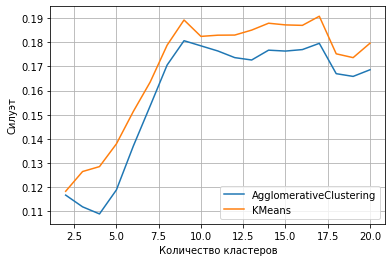

Максимум силуэта достигается при числе кластеров:
- для AgglomerativeClustering 9 
- для Kmeans 17


In [9]:
plt.plot(k, agg_sil, label='AgglomerativeClustering')
plt.plot(k, km_sil, label='KMeans')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')
plt.legend()
plt.grid(True)
plt.show()
print('Максимум силуэта достигается при числе кластеров:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(2+agg_sil.index(max(agg_sil)), 2+km_sil.index(max(km_sil))))

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [10]:
agg_v, km_v = [], []
k = range(2,21)
for i in k:
    agg = AgglomerativeClustering(n_clusters=i)
    km = KMeans(n_clusters=i, n_init=100)
    agg_pred = agg.fit_predict(X, y)
    km_pred = km.fit_predict(X, y)
    agg_v.append(v_measure_score(y, agg_pred))
    km_v.append(v_measure_score(y, km_pred))

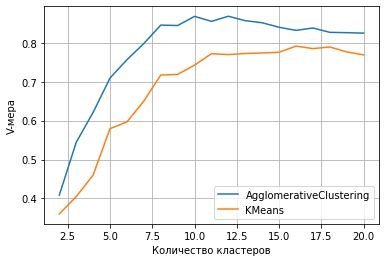

Максимум V-меры достигается при числе кластеров:
- для AgglomerativeClustering 12 
- для Kmeans 16


In [11]:
plt.plot(k, agg_v, label='AgglomerativeClustering')
plt.plot(k, km_v, label='KMeans')
plt.xlabel('Количество кластеров')
plt.ylabel('V-мера')
plt.legend()
plt.grid(True)
plt.show()
print('Максимум V-меры достигается при числе кластеров:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(2+agg_v.index(max(agg_v)), 2+km_v.index(max(km_v))))

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [12]:
comp = [2, 5, 10, 20, 64]
agg_v, km_v = [], []
agg_sil, km_sil = [], []
agg_sil_trunc, km_sil_trunc = [], []

for i in comp:
    if i<64:
        svd = TruncatedSVD(n_components=i)
        X_trunc = svd.fit_transform(X)
    else: X_trunc = X
    
    agg = AgglomerativeClustering(n_clusters=10)
    km = KMeans(n_clusters=10, n_init=100)
    agg_pred = agg.fit_predict(X_trunc, y)
    km_pred = km.fit_predict(X_trunc, y)
    
    agg_sil.append(silhouette_score(X, agg_pred))
    km_sil.append(silhouette_score(X, km_pred))

    agg_sil_trunc.append(silhouette_score(X_trunc, agg_pred))
    km_sil_trunc.append(silhouette_score(X_trunc, km_pred))
    
    agg_v.append(v_measure_score(y, agg_pred))
    km_v.append(v_measure_score(y, km_pred))

__Примечание:__ значения силуэта можно рассчитывать как на основании исходной матрицы `X` (то есть измерять внутри- и межкластерные расстояния в 64-мерном пространстве), так и на основании матрицы `X_trunc` со сниженной размерностью (в пространстве меньшей размерности). Так как нам необходимо ответить на вопрос, улучшился ли силуэт при снижении размерности по сравнению с исходными данными, в данном случае необходимо использовать исходную матрицу `X`. 

Использование матрицы `X_trunc` со сниженной размерностью позволяет увидеть, что кластеры тем более чётко разграничены, чем ниже размерность признакового пространства.

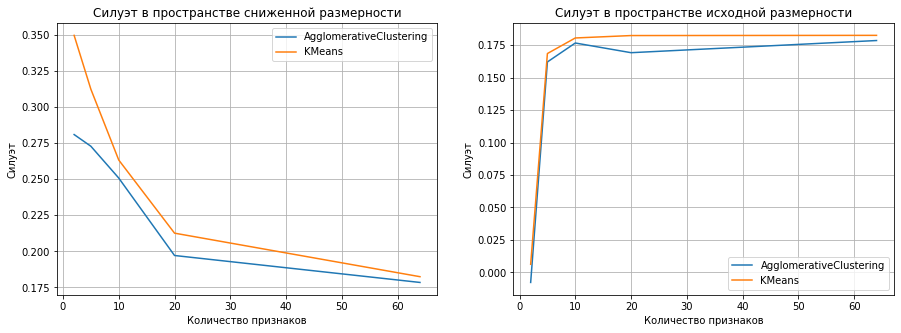

Максимум силуэта достигается при числе признаков:
- для AgglomerativeClustering 64 
- для Kmeans 64


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title('Силуэт в пространстве сниженной размерности')
ax1.plot(comp, agg_sil_trunc, label='AgglomerativeClustering')
ax1.plot(comp, km_sil_trunc, label='KMeans')

ax2.set_title('Силуэт в пространстве исходной размерности')
ax2.plot(comp, agg_sil, label='AgglomerativeClustering')
ax2.plot(comp, km_sil, label='KMeans')

for ax in (ax1, ax2):
    ax.set(xlabel='Количество признаков', ylabel='Силуэт')
    ax.legend()
    ax.grid(True)

plt.show()

print('Максимум силуэта достигается при числе признаков:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(comp[agg_sil.index(max(agg_sil))], comp[km_sil.index(max(km_sil))]))

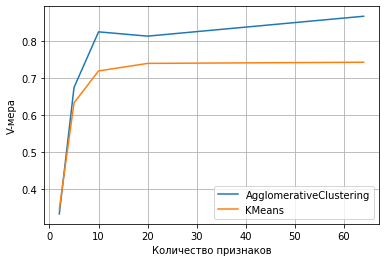

Максимум V-меры достигается при числе признаков:
- для AgglomerativeClustering 64 
- для Kmeans 64


In [14]:
plt.plot(comp, agg_v, label='AgglomerativeClustering')
plt.plot(comp, km_v, label='KMeans')
plt.xlabel('Количество признаков')
plt.ylabel('V-мера')
plt.legend()
plt.grid(True)
plt.show()
print('Максимум V-меры достигается при числе признаков:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(comp[agg_v.index(max(agg_v))], comp[km_v.index(max(km_v))]))

__Ответ:__ Не удалось получить силуэт или V-меру лучше, чем на исходных данных. Тем не менее, на графиках видно, что после `n_components=10` качество кластеризации растёт не так сильно.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [15]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

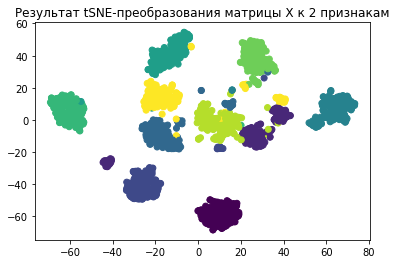

In [16]:
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.title('Результат tSNE-преобразования матрицы X к 2 признакам')
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [17]:
agg = AgglomerativeClustering(n_clusters=10)
km = KMeans(n_clusters=10, n_init=100)
agg_pred = agg.fit_predict(X_tsne, y)
km_pred = km.fit_predict(X_tsne, y)

print('Значения силуэта для tSNE-преобразованных данных с 2 признаками:\n- для AgglomerativeClustering {} \n- для Kmeans {} \n'\
      .format(silhouette_score(X, agg_pred), silhouette_score(X, km_pred)))
print('Значения V-меры для tSNE-преобразованных данных с 2 признаками:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(v_measure_score(y, agg_pred), v_measure_score(y, km_pred)))

Значения силуэта для tSNE-преобразованных данных с 2 признаками:
- для AgglomerativeClustering 0.16368921305330209 
- для Kmeans 0.164224107358976 

Значения V-меры для tSNE-преобразованных данных с 2 признаками:
- для AgglomerativeClustering 0.9078958139179586 
- для Kmeans 0.9065720323057936


In [18]:
print('Значения силуэта для исходных данных:\n- для AgglomerativeClustering {} \n- для Kmeans {} \n'\
      .format(agg_sil[-1], km_sil[-1]))
print('Значения V-меры для исходных данных:\n- для AgglomerativeClustering {} \n- для Kmeans {}'\
      .format(agg_v[-1], km_v[-1]))

Значения силуэта для исходных данных:
- для AgglomerativeClustering 0.17849659940596496 
- для Kmeans 0.18247906918584123 

Значения V-меры для исходных данных:
- для AgglomerativeClustering 0.8681701126909083 
- для Kmeans 0.7438377289780214


__Ответ:__ в результате применения tSNE удалось значительно повысить V-меру, при этом силуэт снизился.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

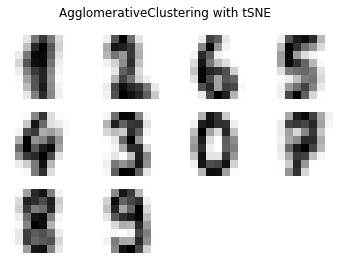

In [19]:
fig, axs = plt.subplots(3, 4)
fig.suptitle('AgglomerativeClustering with tSNE')
for i in range(10):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[agg_pred == i].mean(axis=0).reshape(8,8),cmap=plt.cm.gray_r)
axs.flat[10].set_axis_off()
axs.flat[11].set_axis_off()
plt.show()

__Ответ:__ да, удалось добиться того, чтобы центры кластеров соответствовали одной цифре.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

__Ответ:__

В данном случае мы знаем точное количество кластеров (10). Также мы знаем, что должны из себя представлять центры кластеров (изображения цифр), поэтому кроме метрик оценки качества кластеризации мы можем также учитывать визуальное соответствие центров кластеров какой-либо из цифр.

Ответ на вопрос "Какой из двух методов даёт более осмысленные кластеры?" зависит от метода оценки качества. Силуэт отдаёт предпочтение алгоритмам, которые максимально чётко отделяют кластеры друг от друга. V-мера позволяет оценить, насколько алгоритм соответствует правильному делению на кластеры. Так как в данном случае наша задача состоит в выявлении алгоритма, который максимально точно определяет правильный кластер, выбор необходимо основывать на значении V-меры. При этом визуально это может оказаться не лучшим вариантом (вероятно, из-за различий в рукописном написании одной и той же цифры и усреднения при нахождении центров кластеров).

Как мы выяснили, настройки алгоритмов кластеризации (в частности, основного параметра - числа кластеров) влияют на качество кластеризации. Выбрать оптимальное количество кластеров можно в помощью такой метрики как силуэт.

Снижение размерности признакового пространства иногда позволяет улучшить качество кластеризации. В нашем случае это позволило повысить V-меру, а также визуальное изображение центров кластеров.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [52]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [53]:
X.shape, y.shape

((70000, 784), (70000,))

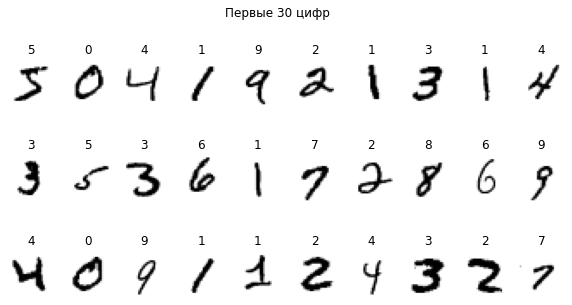

In [54]:
fig, axs = plt.subplots(3, 10, figsize=(10,5))
fig.suptitle('Первые 30 цифр')
for i in range(30):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[i].reshape(28,28),cmap=plt.cm.gray_r)
    axs.flat[i].set_title(y[i])
plt.show()

Начнём с `AgglomerativeClustering`. И закончим, там как не хватает ОЗУ.

Перейдём к `KMeans`. На странице алгоритма указано, что для количества наблюдений >10 тыс. `MiniBatchKMeans` будет работать намного быстрее. Его и будем использовать.

In [55]:
km = MiniBatchKMeans(n_clusters=10)
km_pred = km.fit_predict(X, y)

In [56]:
print('Силуэт для MiniBatchKMeans с 10 кластерами = {}'.format(silhouette_score(X, km_pred)))

Силуэт для MiniBatchKMeans с 10 кластерами = 0.05763259292054906


In [57]:
print('V-мера для MiniBatchKMeans с 10 кластерами = {}'.format(v_measure_score(y, km_pred)))

V-мера для MiniBatchKMeans с 10 кластерами = 0.4455505606573266


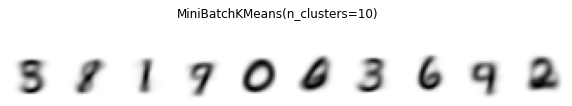

In [58]:
fig, axs = plt.subplots(1, 10, figsize=(10,2))
fig.suptitle('MiniBatchKMeans(n_clusters=10)')
for i in range(10):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[km_pred == i].mean(axis=0).reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

Попробуем улучшить результат путём уменьшения размерности признакового пространства. `tSNE` отрабатывал очень долго, поэтому попробуем `UMAP`.

In [59]:
umap = UMAP()
X_umap = umap.fit_transform(X)

In [60]:
X_umap.shape

(70000, 2)

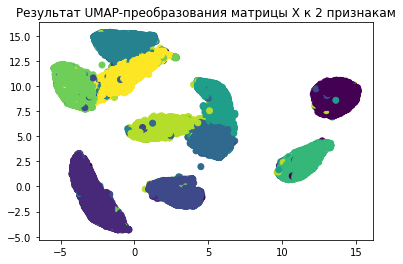

In [61]:
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=y.astype('int32'))
plt.title('Результат UMAP-преобразования матрицы X к 2 признакам')
plt.show()

In [62]:
km_umap = MiniBatchKMeans(n_clusters=10)
km_umap_pred = km_umap.fit_predict(X_umap, y)

In [63]:
print('Силуэт для MiniBatchKMeans с 10 кластерами и UMAP-преобразованием = {}'.format(silhouette_score(X, km_umap_pred)))

Силуэт для MiniBatchKMeans с 10 кластерами и UMAP-преобразованием = 0.033864011958809406


In [64]:
print('V-мера для MiniBatchKMeans с 10 кластерами и UMAP-преобразованием = {}'.format(v_measure_score(y, km_umap_pred)))

V-мера для MiniBatchKMeans с 10 кластерами и UMAP-преобразованием = 0.8478695239132246


V-мера значительно увеличилась, то есть снижение размерности помогло правильнее кластеризовать наблюдения. Силуэт (в исходной размерности) почти не изменился.

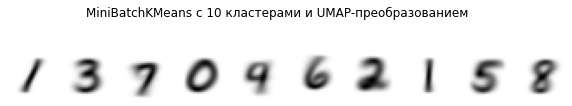

In [65]:
fig, axs = plt.subplots(1, 10, figsize=(10,2))
fig.suptitle('MiniBatchKMeans с 10 кластерами и UMAP-преобразованием')
for i in range(10):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[km_umap_pred == i].mean(axis=0).reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

Несмотря на возросшую V-меру, визуально алгоритм частично объединил 4, 7 и 9, а также выдал две единицы.

Люди могут писать одну и ту же цифру немного по-разному. Поэтому мне кажется, что алгоритму может быть легче разделить наблюдения на более чем 10 кластеров. Затем на основании визуального анализа можно объединить несколько кластеров с разным написанием одной и той же цифры в один.

In [66]:
km_v, km_sil = [], []
k = range(10,16)
for i in k:
  km_umap = MiniBatchKMeans(n_clusters=i)
  km_umap_pred = km_umap.fit_predict(X_umap, y)
  km_v.append(v_measure_score(y, km_umap_pred))
  km_sil.append(silhouette_score(X_umap, km_umap_pred))

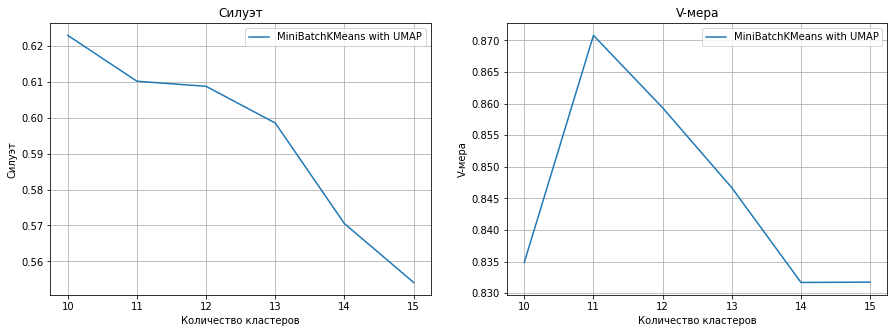

Максимум метрик достигается при числе кластеров:
- Силуэт 0.6229492425918579 при 10 кластерах
- V-мера 0.8708024022606204 при 11 кластерах


In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title('Силуэт')
ax1.plot(k, km_sil, label='MiniBatchKMeans with UMAP')
ax1.set(ylabel='Силуэт')

ax2.set_title('V-мера')
ax2.plot(k, km_v, label='MiniBatchKMeans with UMAP')
ax2.set(ylabel='V-мера')

for ax in (ax1, ax2):
    ax.set(xlabel='Количество кластеров')
    ax.legend()
    ax.grid(True)

plt.show()

print('Максимум метрик достигается при числе кластеров:\n- Силуэт {} при {} кластерах\n- V-мера {} при {} кластерах'\
      .format(max(km_sil),k[km_sil.index(max(km_sil))], max(km_v),k[km_v.index(max(km_v))]))

__Примечание:__ когда я в первый раз запускал этот код, максимум силуэта был при 11 кластерах. Поэтому я решил попробовать 11 кластеров и затем объединение двух из них в один. В последующие разы график выглядел по-другому.

Но даже без этого было бы логично попробовать 11 кластеров, так как при 10 кластерах мы наблюдали выделение двух кластеров для цифры 1.

In [68]:
km_umap = MiniBatchKMeans(n_clusters=11)
km_umap_pred = km_umap.fit_predict(X_umap, y)

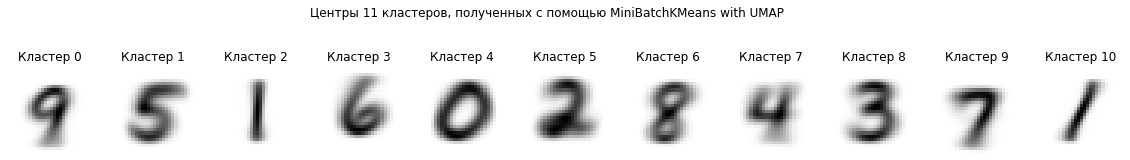

In [69]:
fig, axs = plt.subplots(1, 11, figsize=(20,3))
fig.suptitle('Центры 11 кластеров, полученных с помощью MiniBatchKMeans with UMAP')
for i in range(11):
    axs.flat[i].set_axis_off()
    axs.flat[i].imshow(X[km_umap_pred == i].mean(axis=0).reshape(28,28),cmap=plt.cm.gray_r)
    axs.flat[i].set_title('Кластер {}'.format(i))
plt.show()

Теперь все цифры отчётливо отделены, у нас получилось 2 кластера единиц. Объединим их.

In [70]:
km_umap_pred2 = np.where(km_umap_pred==10, 2, km_umap_pred)

In [71]:
print('V-мера для MiniBatchKMeans с 11-1=10 кластерами и UMAP-преобразованием = {}'.format(v_measure_score(y, km_umap_pred2)))


V-мера для MiniBatchKMeans с 11-1=10 кластерами и UMAP-преобразованием = 0.8906315973695479


Выделение 11 кластеров и последующее объединение двух из них позволило добиться максимального значения V-меры, а значит, максимально точно идентифицировать рукописные цифры.